In [1]:
import pandas as pd
import numpy as np
from sklearn import metrics
import math
import matplotlib.pyplot as plt
from collections import defaultdict
from functools import partial
from itertools import repeat
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Activation
import keras.backend as K

Using TensorFlow backend.


In [2]:
dataDir = "/Users/brandonmanley/Documents/nBody/data/brutusSim/"
workDir = "/Users/brandonmanley/Documents/nBody/data/"
idCols = ['file', 'eventID']
i_col = ["m1","m2", "m3", "x1", "x2", "x3", "y1", "y2","y3",
		"dx1","dx2", "dx3", "dy1","dy2", "dy3", "t"]

o_col = ["xf1", "xf2","xf3",  "yf1", "yf2","yf3",
		"dxf1", "dxf2", "dxf3", "dyf1", "dyf2", "dyf3"]

#Import data
df = pd.read_csv(dataDir + "brutus10_1_2.csv")
df = df.drop(columns="Unnamed: 21")

df3 = pd.read_csv(dataDir + "brutus10_4_3.csv", names = idCols+ i_col+o_col, index_col=False)

# add 3rd body columns
labelsToAdd = ['m3', 'x3', 'y3', 'dx3', 'dy3', 'xf3', 'yf3', 'dyf3', 'dxf3']
for label in labelsToAdd:
#     dfShuffle[label] = pd.Series([0 for x in range(len(dfShuffle.index)+1)])
    df[label] = 0
    

print(df.shape)
print(df.shape[0]/2560)

(456882, 30)
178.46953125


In [3]:
# grab three body data 
print(df3.shape)
print(df3.shape[0]/2560)

df3_cut = df3.iloc[:df.shape[0], ]

print(df3_cut.shape)

df_combined = df.append(df3_cut, sort=True)
print(df_combined.shape)

(928290, 30)
362.61328125
(456882, 30)
(913764, 30)


In [4]:
dfShuffle = shuffle(df_combined,random_state=42)

X1 = dfShuffle.as_matrix(columns=i_col)
y1 = dfShuffle.as_matrix(columns=o_col)

X_train,X_test,y_train,y_test = train_test_split(X1,y1, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

print(y_train.shape,y_test.shape)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(731011, 16) (731011, 12)
(182753, 16) (182753, 12)
(731011, 12) (182753, 12)


Train on 731011 samples, validate on 182753 samples
Epoch 1/30
731011/731011 [==============================] - 5s 7us/step - loss: 9.6928 - accuracy: 0.4848 - val_loss: 6.8768 - val_accuracy: 0.5736
Epoch 2/30
731011/731011 [==============================] - 5s 6us/step - loss: 5.8537 - accuracy: 0.6116 - val_loss: 5.1818 - val_accuracy: 0.6241
Epoch 3/30
731011/731011 [==============================] - 4s 6us/step - loss: 4.5324 - accuracy: 0.6493 - val_loss: 4.1141 - val_accuracy: 0.6663
Epoch 4/30
731011/731011 [==============================] - 5s 6us/step - loss: 3.8288 - accuracy: 0.6740 - val_loss: 3.4975 - val_accuracy: 0.6901
Epoch 5/30
731011/731011 [==============================] - 5s 6us/step - loss: 3.4389 - accuracy: 0.6971 - val_loss: 3.2335 - val_accuracy: 0.7157
Epoch 6/30
731011/731011 [==============================] - 5s 6us/step - loss: 3.2323 - accuracy: 0.7137 - val_loss: 3.1152 - val_accuracy: 0.7252
Epoch 7/30
731011/731011 [==============================] - 

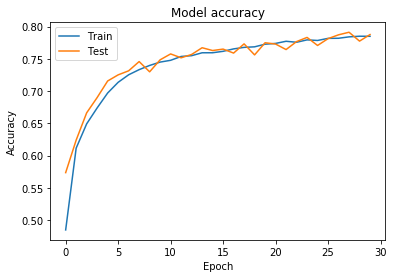

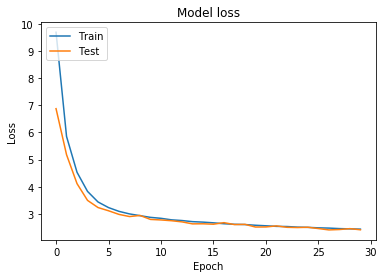

In [5]:
def modified_mse(y_true,y_pred): # FIXME: Update for 2 bodies

	masses = y_true[:, 2]

	#initial positions
	p0 = y_true[:, 3:8] 

	#final positions and velocities
	y_true = y_true[:,10:]

	#predicted final positions and velocities
	p1 = y_pred

	#mean squared error between predicted and true
	mse = K.mean(K.square(y_pred-y_true),axis=-1)

	#intial and final CM, delta
	cm_x_i = (masses[0]*p0[0]+masses[1]*p0[1]+masses[2]*p0[2])/(masses[0]+masses[1]+masses[2])
	cm_y_i = (masses[0]*p0[3]+masses[1]*p0[4]+masses[2]*p0[4])/(masses[0]+masses[1]+masses[2])
	cm_x_f = (masses[0]*p1[0]+masses[1]*p1[1]+masses[2]*p1[2])/(masses[0]+masses[1]+masses[2])
	cm_y_f = (masses[0]*p1[3]+masses[1]*p1[4]+masses[2]*p1[4])/(masses[0]+masses[1]+masses[2])
	delta_cm_x = abs(cm_x_i-cm_x_f)
	delta_cm_y = abs(cm_y_i-cm_y_f)

	return mse



#parameters 
max_epochs = 30
optimizer = 'adam'
batch_size = 5000       #FIXME: paper used 5000 for 10000 events

network = models.Sequential()
network.add(layers.Dense(128,activation='relu',input_dim=len(i_col)))
for i in range(5):
	network.add(layers.Dense(128,activation='relu'))
network.add(layers.Dense(len(o_col),activation='linear'))
network.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
network.save_weights(workDir + 'weights/model_init.h5')

history = network.fit(X_train,y_train,
                              epochs=max_epochs,
                              batch_size=batch_size,
                              validation_data=(X_test,y_test),
                              verbose = 1)

training_vals_acc = history.history['accuracy']
training_vals_loss = history.history['loss']
valid_vals_acc = history.history['val_accuracy']
valid_vals_loss = history.history['val_loss']
# iterations = len(training_vals_acc)
# print("Number of iterations:",iterations)
# print("Epoch\t Train Loss\t Train Acc\t Val Loss\t Val Acc")
# i = 0
# for tl,ta,vl,va in zip(training_vals_loss,training_vals_acc,valid_vals_loss,valid_vals_acc):
#     print(i,'\t',round(tl,5),'\t',round(ta,5),'\t',round(vl,5),'\t',round(va,5))
#     i += 1

# Plot training & validation accuracy values
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(workDir + 'model_accuracy.png')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(workDir + 'model_loss.png')
plt.show()